In [3]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# load data
data_path = './FiveCitiePMData/BeijingPM20100101_20151231.csv'
df = pd.read_csv(data_path)
selected_columns = ["year","month","day","hour","season","PM_Dongsi","HUMI","TEMP","PRES","Iws","precipitation","PM_Dongsihuan"]
weather_df = df.filter(selected_columns).dropna()
weather_df['season'] = weather_df['season'].astype('category')

# Testing models

- SVM (SVR)
- RF (Random Forest)

In [5]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import datetime as dt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_y_pred_vs_test(y_pred, y_test):
    y_results = pd.DataFrame({'y_target': y_test, 'y_pred':y_pred })
    
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    plt.figure(figsize=(18,6))
    sns.lineplot(data=y_results[-100:])
    # sns.lineplot(data=y_pred)
    plt.show()
    
def compute_errors_y_pred_vs_test(y_pred, y_test, label='computing errors:'):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f'{label}', '+'*30, '\n')
    print(f'mae: {mae}', f'mse: {mse}', f'rmse: {rmse}', f'r2: {r2}')


train_df, test_df = train_test_split(weather_df, test_size=0.3, random_state=42) 
train_df.describe()

# train_df["precipitation"].hasnans

# y = train_df["PM_Dongsi"]
# X = train_df[["season","HUMI","TEMP","PRES","Iws","precipitation"]]

# X['datetime'] = X['datetime'].map(X['datetime'].toordinal)
# X['datetime'] = X['datetime'].map(dt.datetime.toordinal)



,year,month,day,hour,PM_Dongsi,HUMI,TEMP,PRES,Iws,precipitation,PM_Dongsihuan
count,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000,13808.000000
mean,2013.927651,6.400710,15.488050,11.499203,86.345814,51.390607,14.179244,1015.207851,21.435246,0.051101,91.904621
std,0.764172,3.297976,8.725156,6.950466,82.315695,25.579475,11.484792,10.241813,47.057296,0.635300,87.519571
min,2013.000000,1.000000,1.000000,0.000000,3.000000,2.000000,-12.000000,992.000000,0.450000,0.000000,3.000000
25%,2013.000000,4.000000,8.000000,5.000000,25.000000,29.000000,4.000000,1007.000000,1.790000,0.000000,28.000000
50%,2014.000000,6.000000,15.000000,11.000000,64.000000,52.000000,16.000000,1015.000000,4.920000,0.000000,68.000000
75%,2015.000000,9.000000,23.000000,18.000000,121.000000,73.000000,24.000000,1023.000000,19.680000,0.000000,126.000000
max,2015.000000,12.000000,31.000000,23.000000,737.000000,100.000000,39.000000,1041.000000,490.380000,29.000000,672.000000


## Method: Support Vector Regressor (SVR)

In [22]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# import numpy as np
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

y = train_df["PM_Dongsi"]
X = train_df[["season","HUMI","TEMP","PRES","Iws","precipitation","PM_Dongsihuan"]]

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [23]:
X_test = test_df[["season","HUMI","TEMP","PRES","Iws","precipitation","PM_Dongsihuan"]]
y_test = test_df["PM_Dongsi"]

y_pred = regr.predict(X_test)

mae: 19.864017102528024 mse: 1435.2200198524222 rmse: 37.88429780070395 r2: 0.8003710469684455


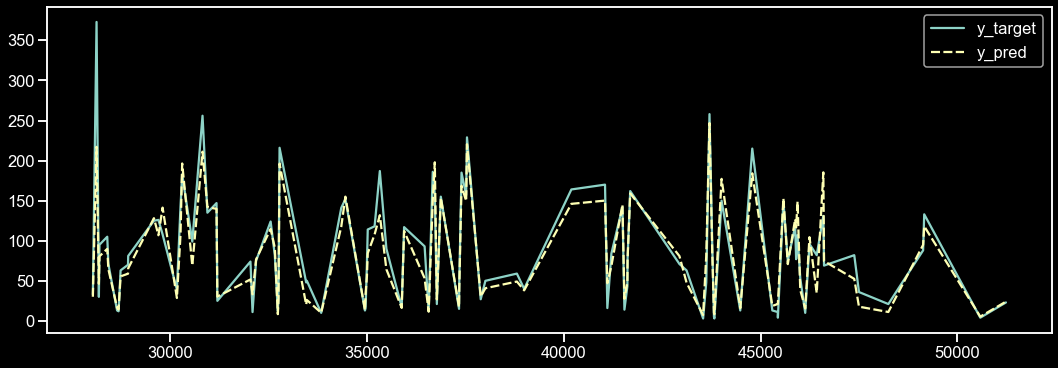

In [24]:
compute_errors_y_pred_vs_test(y_pred, y_test)
plot_y_pred_vs_test(y_pred, y_test)


## Method: Exhaustive Feature Selection (EFS) + Linear Regressor

In [28]:
### EFS utils

from mlxtend.feature_selection import ExhaustiveFeatureSelector

def get_extracted_features(X, y, model, num_features = 1):
    efs = ExhaustiveFeatureSelector(model, 
               min_features=(2 if num_features > 2 else 1),
               max_features=num_features, 
               scoring='r2',
               cv=2)

    # fit the object to the training data.
    efs = efs.fit(X, y)

    # print the selected features.
    selected_features = X.columns[list(efs.best_idx_)]
    print(selected_features)

    # print the final prediction score.
    print('Best accuracy score: %.2f' % efs.best_score_)
    print('Best subset (indices):', efs.best_idx_)
    print('Best subset (corresponding names):', efs.best_feature_names_)

    return efs

    

In [30]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# import the algorithm you want to evaluate on your features.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

_x_fields = ["season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan"]

X_train = train_df[_x_fields]
y_train = train_df['PM_Dongsi']

X_test = test_df[_x_fields]
y_test = test_df['PM_Dongsi']

efs = get_extracted_features(X_train, y_train, model, len(_x_fields))
# transform to the newly selected features.
X_train_efs = efs.transform(X_train)
X_test_efs = efs.transform(X_test)

model = LinearRegression()

model.fit(X_train_efs, y_train)

Features: 120/120

Index(['season', 'TEMP', 'PRES', 'Iws', 'PM_Dongsihuan'], dtype='object')
Best accuracy score: 0.87
Best subset (indices): (0, 2, 3, 4, 6)
Best subset (corresponding names): ('season', 'TEMP', 'PRES', 'Iws', 'PM_Dongsihuan')


LinearRegression()

In [31]:
y_pred = model.predict(X_test_efs) 

mae: 18.42698639876149 mse: 909.3757755866757 rmse: 30.15585806417512 r2: 0.8735122618960591


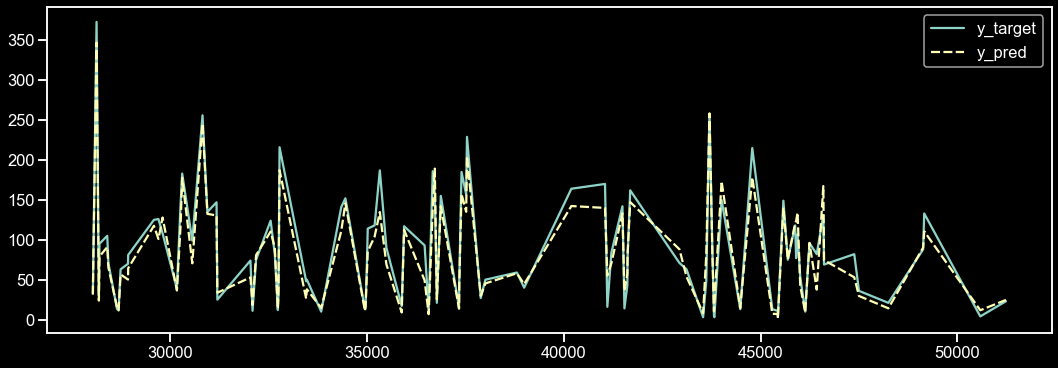

In [32]:
compute_errors_y_pred_vs_test(y_pred, y_test)
plot_y_pred_vs_test(y_pred, y_test)

## Method: Exhaustive Feature Selection (EFS) + Multilayer Perceptron

Test cases considered:

- considering all features (7)
- considering just 3 features (TEMP, HUM, PM_Dongsihuan) 

In [47]:

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

test_cases = [
    { 
        'title': 'with 7 variables',
        'description': 'variables: "season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan"',
        'x_fields': ["season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan"]
    },
    { 
        'title': 'with 3 variables',
        'description': 'variables: HUMI, TEMP, PM_Dongsihuan',
        'x_fields': ["HUMI", "TEMP", "PM_Dongsihuan"]
    }
]
models = []
X_tests = []

for test_case in test_cases:
    X_train = train_df[test_case['x_fields']]
    y_train = train_df['PM_Dongsi']

    X_test = test_df[test_case['x_fields']]
    y_test = test_df['PM_Dongsi']

    efs = get_extracted_features(X_train, y_train, model, len(test_case['x_fields']))
    X_train_efs = efs.transform(X_train)
    X_test_efs = efs.transform(X_test)

    sc_X = StandardScaler()
    X_trainscaled=sc_X.fit_transform(X_train_efs)
    X_testscaled=sc_X.transform(X_test_efs)
    X_tests.append(X_testscaled)

    mlpregressor = MLPRegressor(
        hidden_layer_sizes=(64,64,64),
        activation="relu",
        random_state=1,
        max_iter=2000
    ).fit(X_trainscaled, y_train)
    
    models.append(mlpregressor)


Features: 120/120

Index(['season', 'HUMI', 'TEMP', 'Iws', 'precipitation', 'PM_Dongsihuan'], dtype='object')
Best accuracy score: 0.87
Best subset (indices): (0, 1, 2, 4, 5, 6)
Best subset (corresponding names): ('season', 'HUMI', 'TEMP', 'Iws', 'precipitation', 'PM_Dongsihuan')


Features: 4/4

Index(['HUMI', 'TEMP', 'PM_Dongsihuan'], dtype='object')
Best accuracy score: 0.87
Best subset (indices): (0, 1, 2)
Best subset (corresponding names): ('HUMI', 'TEMP', 'PM_Dongsihuan')


prediciton with with 7 variables 
(variables: "season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan") ++++++++++++++++++++++++++++++ 

mae: 16.770240769001415 mse: 735.6665397396841 rmse: 27.12317348209247 r2: 0.897673987906272


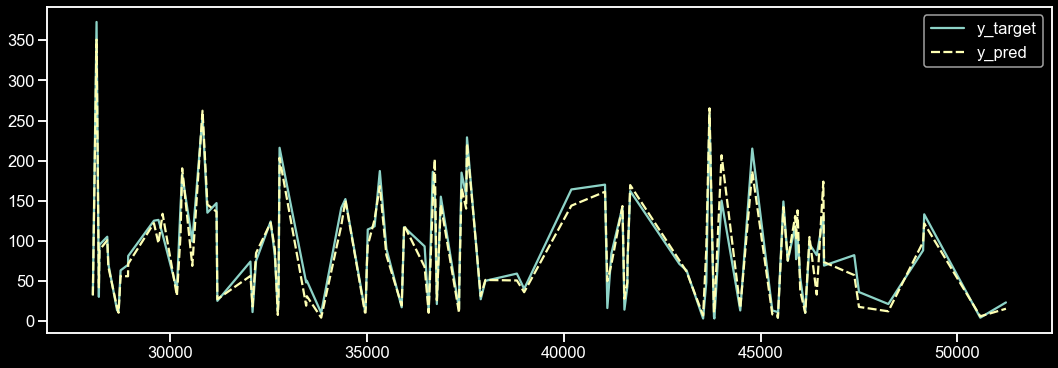

prediciton with with 3 variables 
(variables: HUMI, TEMP, PM_Dongsihuan) ++++++++++++++++++++++++++++++ 

mae: 18.012881072582687 mse: 845.2399427192049 rmse: 29.073010554794717 r2: 0.8824331025964672


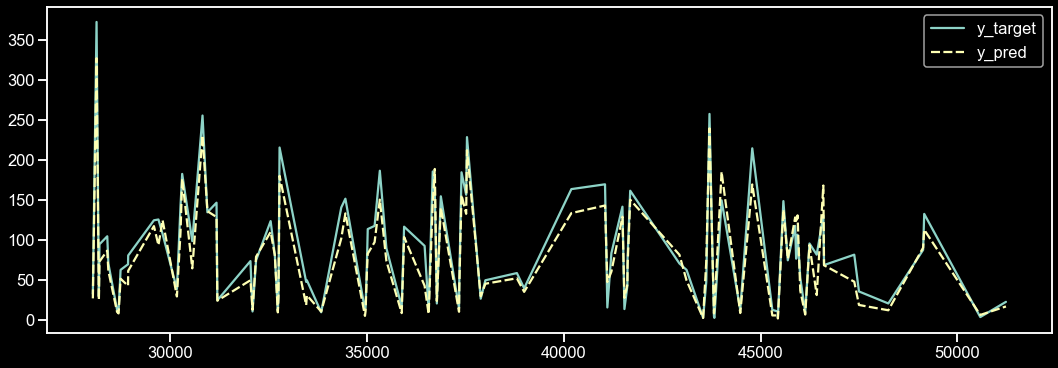

In [48]:
for i, model in enumerate(models):
    X_test = X_tests[i]
    y_test = test_df['PM_Dongsi']
    
    y_pred = model.predict(X_test)
    title = test_cases[i]['title']
    description = test_cases[i]['description']
    compute_errors_y_pred_vs_test(y_pred, y_test, label=f'prediciton with {title} \n({description})')
    plot_y_pred_vs_test(y_pred, y_test)


## Method: Experimenting with SKLearn AutoML

In [6]:
import sklearn.datasets
import sklearn.metrics

import autosklearn.regression


In [7]:
test_cases = [
    { 
        'title': 'with 7 variables',
        'description': 'variables: "season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan"',
        'x_fields': ["season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan"]
    },
    { 
        'title': 'with 3 variables',
        'description': 'variables: HUMI, TEMP, PM_Dongsihuan',
        'x_fields': ["HUMI", "TEMP", "PM_Dongsihuan"]
    }
]
automodels = []
X_tests=[]

for i, test_case in enumerate(test_cases):
    X_train = train_df[test_case['x_fields']]
    y_train = train_df['PM_Dongsi']

    X_test = test_df[test_case['x_fields']]
    X_tests.append(X_test)
    y_test = test_df['PM_Dongsi']

    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
        tmp_folder=f'/tmp/autosklearn_regression_example_tmp_{i}',
        output_folder=f'/tmp/autosklearn_regression_example_out_{i}',
    )
    automl.fit(X_train, y_train, dataset_name='air_pollution_{i}')
    automodels.append(automl)



In [9]:
print(automl.show_models())

[(0.360000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'select_rates_regression', 'regressor:__choice__': 'gradient_boosting', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.000400759453878678, 'feature_preprocessor:select_rates_regression:alpha': 0.09988990258830989, 'feature_preprocessor:select_rates_regression:mode': 'fpr', 'feature_preprocessor:select_rates_regression:score_func': 'f_regression', 'regressor:gradient_boosting:early_stop': 'off', 'regressor:gradient_boosting:l2_regularization': 3.0002886744200357e-06, 'regressor:gradient_boosting:learning_rate': 0.015673

prediciton with with 7 variables 
(variables: "season","HUMI","TEMP","PRES","Iws","precipitation", "PM_Dongsihuan") ++++++++++++++++++++++++++++++ 

mae: 15.83367785104387 mse: 653.8329755513993 rmse: 25.570157910177233 r2: 0.9090564578521884


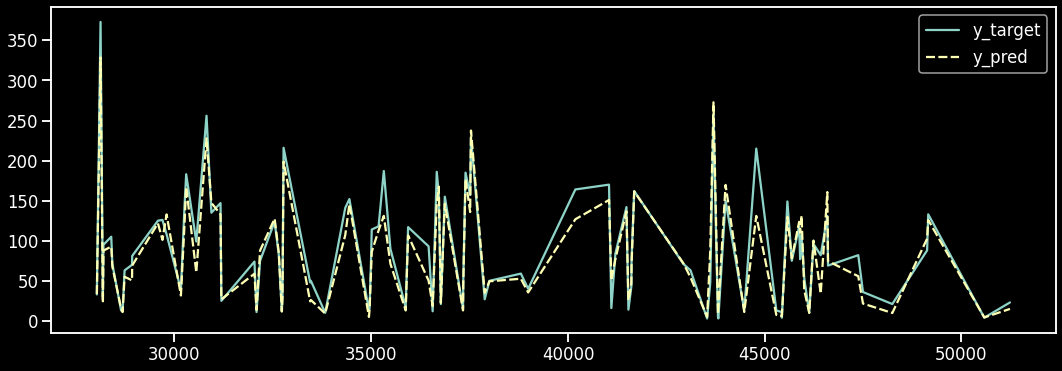

prediciton with with 3 variables 
(variables: HUMI, TEMP, PM_Dongsihuan) ++++++++++++++++++++++++++++++ 

mae: 17.255329094254975 mse: 786.280805703928 rmse: 28.040699094422163 r2: 0.8906339015201152


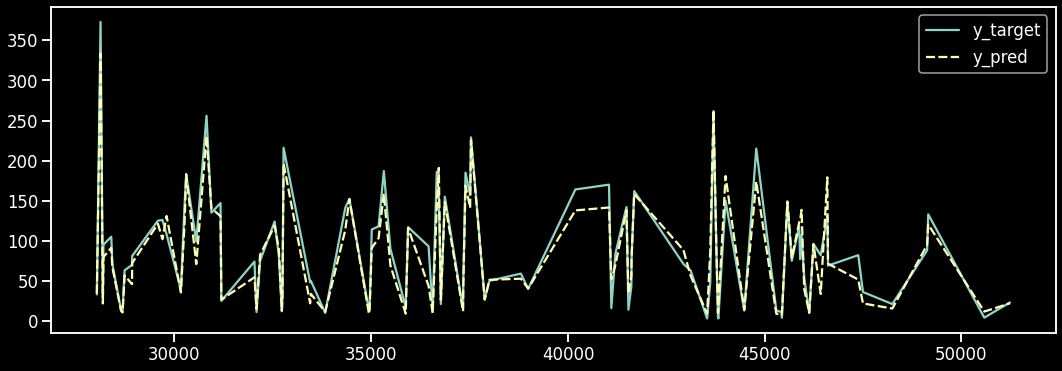

In [10]:
for i, model in enumerate(automodels):
    X_test = test_df[test_cases[i]['x_fields']]
    y_test = test_df['PM_Dongsi']
    
    y_pred = model.predict(X_test)

    title = test_cases[i]['title']
    description = test_cases[i]['description']
    
    compute_errors_y_pred_vs_test(y_pred, y_test, label=f'prediciton with {title} \n({description})')
    plot_y_pred_vs_test(y_pred, y_test)
    
# predictions = automl.predict(X_test)
# print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))